# Importing Libraries

In [2]:
# Data Manipulation & Visualization
import os
import pandas as pd
import numpy as np
import seaborn as sns # used for plot interactive graph. 
sns.set_style('darkgrid')
import matplotlib.pyplot as plt


# Text Manipulation
import re
from wordcloud import STOPWORDS
from nltk import FreqDist, word_tokenize
from nltk import bigrams, trigrams
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,mean_squared_error,mean_absolute_error,log_loss,accuracy_score,classification_report
from sklearn.metrics import precision_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

# Loading data

In [3]:
train = pd.read_csv("C:/Users/91767/Downloads/Product Sentiment Classification-AI_ML-Test-2/Train.csv")
test = pd.read_csv("C:/Users/91767/Downloads/Product Sentiment Classification-AI_ML-Test-2/Test.csv")
samp = pd.read_csv("C:/Users/91767/Downloads/Product Sentiment Classification-AI_ML-Test-2/Sample Submission.csv")

In [4]:
# we take only what we need
train = train[['Product_Description','Product_Type','Sentiment']]

In [5]:
train.columns

Index(['Product_Description', 'Product_Type', 'Sentiment'], dtype='object')

In [6]:
train.head()

,Product_Description,Product_Type,Sentiment
0,The Web DesignerÛªs Guide to iOS (and Android...,9,2
1,RT @mention Line for iPad 2 is longer today th...,9,2
2,Crazy that Apple is opening a temporary store ...,9,2
3,The lesson from Google One Pass: In this digit...,9,2
4,RT @mention At the panel: &quot;Your mom has a...,9,2


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Product_Description  6364 non-null   object
 1   Product_Type         6364 non-null   int64 
 2   Sentiment            6364 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 149.3+ KB


In [10]:
train.shape

(6364, 3)

In [11]:
test.head(5)

,Text_ID,Product_Description,Product_Type
0,5786,RT @mention Going to #SXSW? The new iPhone gui...,7
1,5363,RT @mention 95% of iPhone and Droid apps have ...,9
2,6716,RT @mention Thank you to @mention for letting ...,9
3,4339,#Thanks @mention we're lovin' the @mention app...,7
4,66,At #sxsw? @mention / @mention wanna buy you a ...,9


In [12]:
test.shape

(2728, 3)

In [13]:
samp.head(3)

,0,1,2,3
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0


# EDA

In [14]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


C:\Users\91767\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


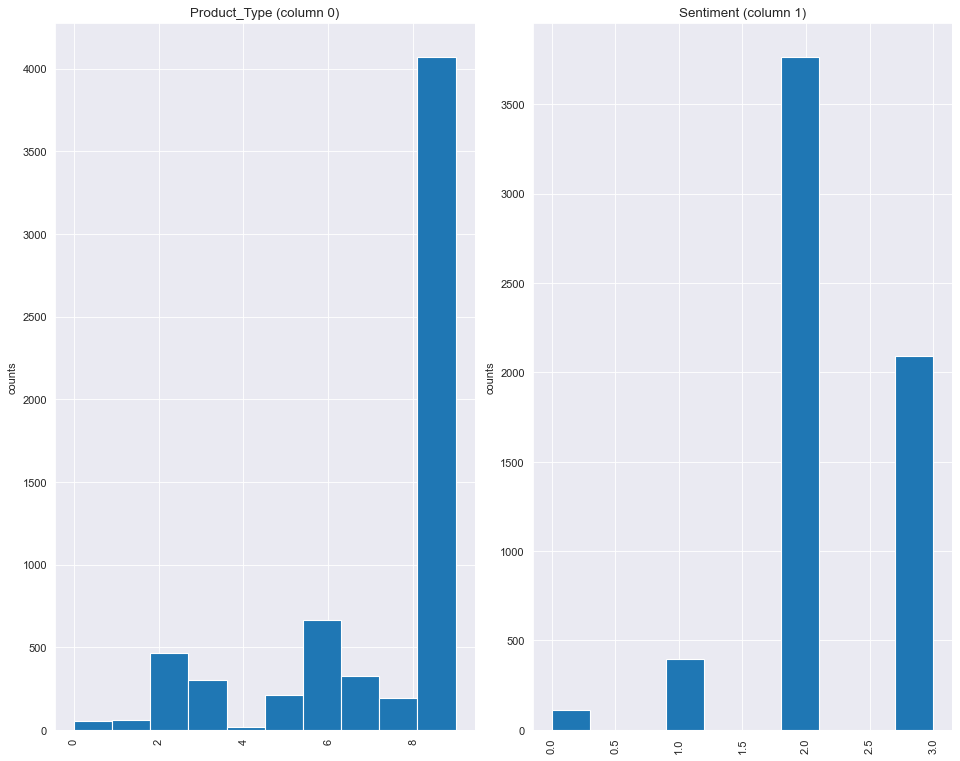

In [15]:
plotPerColumnDistribution(train, 10, 5)

No handles with labels found to put in legend.


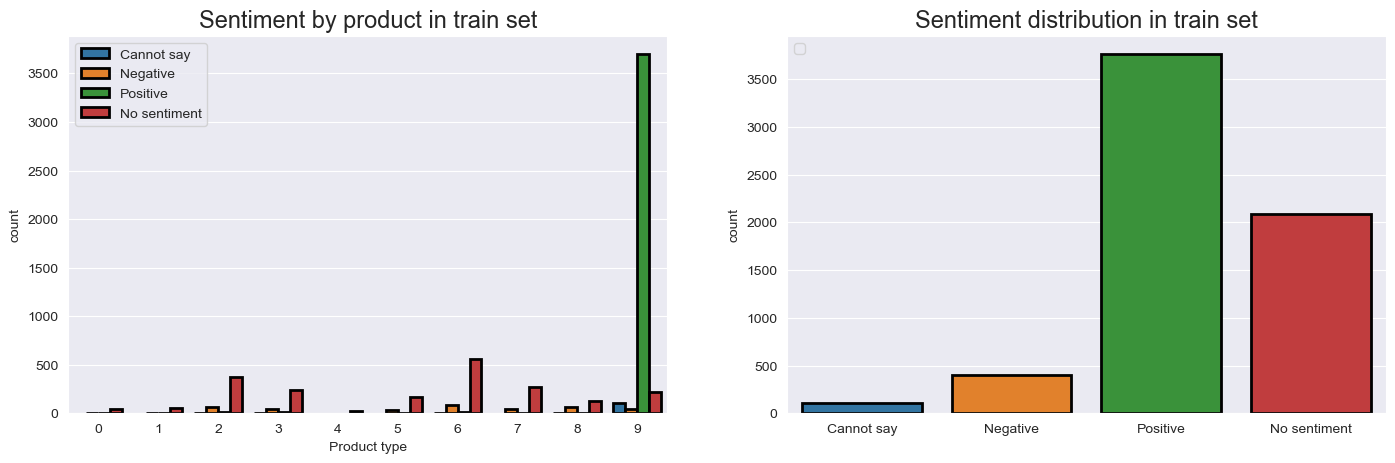

In [16]:
fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(17,5))
sns.countplot(data=train,x="Product_Type",hue="Sentiment",edgecolor="black",ax=ax[0],linewidth=2)
ax[0].legend(loc="upper left",labels=["Cannot say","Negative","Positive","No sentiment"])
ax[0].set_title('Sentiment by product in train set',size=17)
ax[0].set_xlabel("Product type")

sns.countplot(data=train,x="Sentiment",edgecolor="black",ax=ax[1],linewidth=2)
ax[1].legend(loc="upper left")
ax[1].set_title('Sentiment distribution in train set',size=17)
ax[1].set_xticklabels(["Cannot say","Negative","Positive","No sentiment"])
ax[1].set_xlabel("")

plt.show() 


Positive sentiment is focused only on 9th Product and overall the most present sentiment is Positive(2) and Neutral(3)

In [17]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

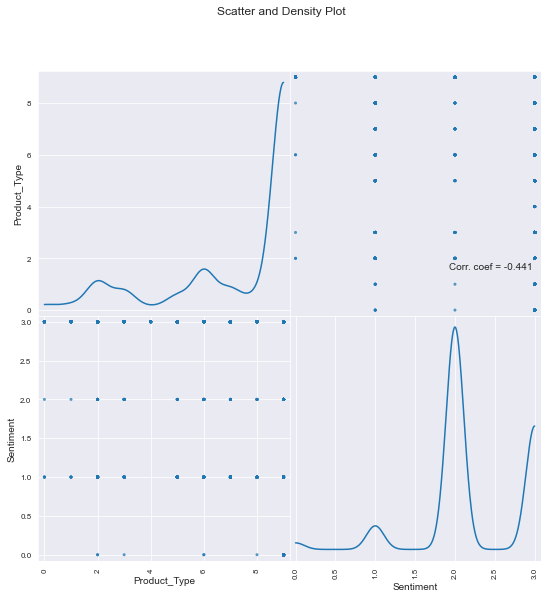

In [18]:
plotScatterMatrix(train, 9, 10)

# Text Cleaning

In [19]:
test_str = train.loc[0, 'Product_Description']

def clean_text(text):
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text=  re.sub('@mention',' ', text )
    text=  re.sub('{link}',' ', text )
    text=  re.sub('Ûª',' ', text )
    text=  re.sub('  ',' ', text )
    text=  re.sub('RT',' ', text )
    text=  re.sub('//',' ', text )
    text=  re.sub('&quot',' ', text )
    text=  re.sub('&amp',' ', text )
    text=  re.sub(r'[^\w\s]',' ', text )
    text=  re.sub(' +',' ', text )
    return text

def process_text(df):
    df['description'] = df['Product_Description'].apply(lambda x: clean_text(x))
    return df

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: The Web DesignerÛªs Guide to iOS (and Android) Apps, today @mention 10 a.m! {link} #sxsw
Cleaned text: The Web Designer s Guide to iOS and Android Apps today 10 a m sxsw


In [20]:
train = process_text(train)
test = process_text(test)
train.drop('Product_Description',1,inplace=True)
test.drop('Product_Description',1,inplace=True)

# Text Analysis

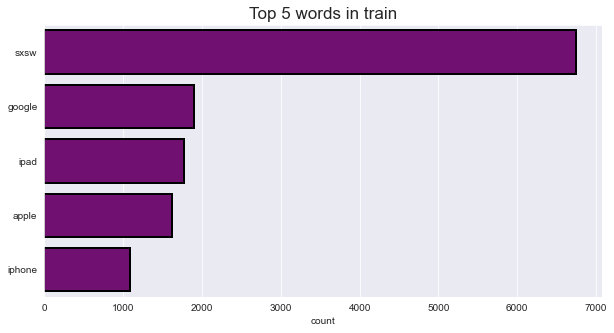

In [21]:
plt.figure(figsize=(10,5))
word_freq = FreqDist(w for w in word_tokenize(' '.join(train['description']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(5)
last20w=df_word_freq.sort_values('count',ascending=False).tail(5)

sns.barplot(top20w['count'],top20w.index,color='purple',edgecolor="black",linewidth=2)
plt.title("Top 5 words in train",size=17)
plt.show()

# Top 10 Bigrams and Trigrams

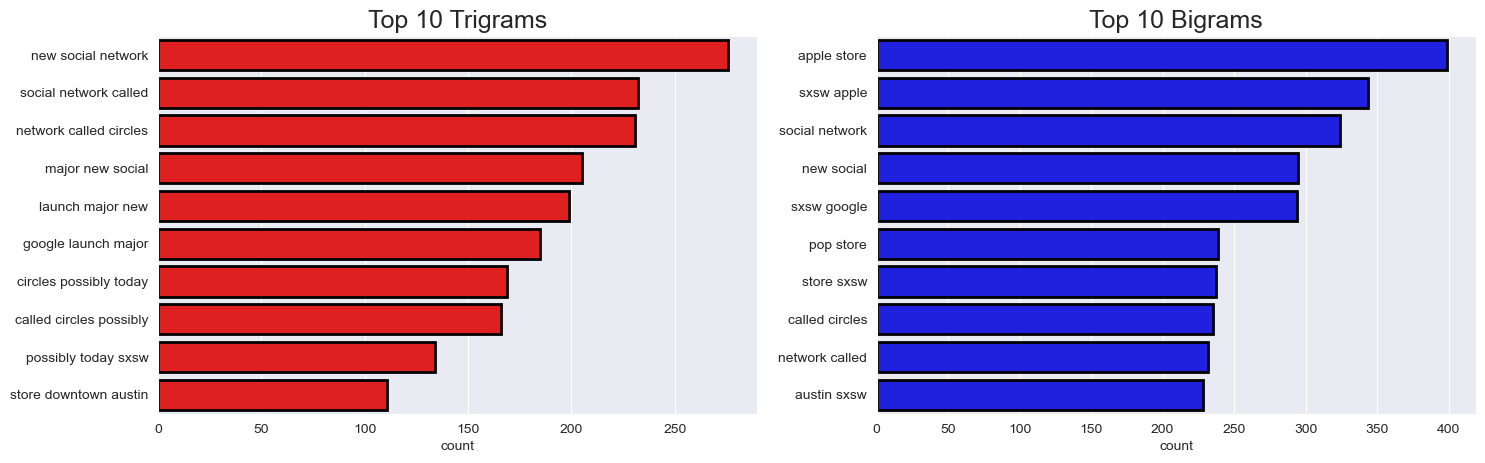

In [22]:
fig,axes=plt.subplots(ncols=2,figsize=(17,5),dpi=100)
###bigrams
bigram = list(bigrams([w for w in word_tokenize(' '.join(train['description']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
fq = FreqDist(bg for bg in bigram)
bgdf = pd.DataFrame.from_dict(fq, orient='index', columns=['count'])
bgdf.index = bgdf.index.map(lambda x: ' '.join(x))
bgdf = bgdf.sort_values('count',ascending=False)

#trigrams
trigram = list(trigrams([w for w in word_tokenize(' '.join(train['description']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
tr_fq = FreqDist(bg for bg in trigram)
trdf = pd.DataFrame.from_dict(tr_fq, orient='index', columns=['count'])
trdf.index = trdf.index.map(lambda x: ' '.join(x))
trdf = trdf.sort_values('count',ascending=False)

sns.barplot(bgdf.head(10)['count'], bgdf.index[:10], ax=axes[1],color='blue',edgecolor='black',linewidth=2)
sns.barplot(trdf.head(10)['count'], trdf.index[:10],ax=axes[0], color='red',edgecolor='black',linewidth=2)

axes[0].set_title('Top 10 Trigrams',size=18)
axes[1].set_title('Top 10 Bigrams',size=18)

plt.show()

# WordCloud

In [23]:
from autoviml.Auto_ViML import Auto_ViML

[nltk_data] Error loading popular: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>



Imported Auto_NLP version: 0.0.45.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)
Imported Auto_ViML version: 0.1.669. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=1)
            
To remove previous versions, perform 'pip uninstall autoviml'
    NEW! Auto_ViML can solve multi-label, multi-output problems!
To get the latest version, perform "pip instal

In [24]:
train = pd.read_csv("C:/Users/91767/Downloads/Product Sentiment Classification-AI_ML-Test-2/Train.csv")
test = pd.read_csv("C:/Users/91767/Downloads/Product Sentiment Classification-AI_ML-Test-2/Test.csv")
samp = pd.read_csv("C:/Users/91767/Downloads/Product Sentiment Classification-AI_ML-Test-2/Sample Submission.csv")

In [25]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, 6364):
  review = re.sub('[^a-zA-Z]', ' ', train['Product_Description'][i])
  review = review.lower()
  review = review.split()
  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.append('sxsw')
  all_stopwords.append('continues')
  all_stopwords.append('oil')
  all_stopwords.append('delivering')
  review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [26]:
print(corpus)

['web design guid io android app today mention link', 'rt mention line ipad longer today yesterday get line today fun', 'crazi appl open temporari store austin tomorrow handl rabid eye pad seeker', 'lesson googl one pass digit environ user want purchas across everi platform one tool elonsxsw', 'rt mention panel quot mom ipad design boomer quot', 'rt mention think ef hubbi line ipad someon point toward line wife number sxswi', 'quot android user iphon user use option menu contextu menu quot mention', 'wow rt mention interrupt regularli schedul geek program big news link googl circl', 'googl launch new social network call circl possibl today link link', 'mention welcom enjoy ride anywher austin dwnld groundlink app link booth', 'rt mention appl plan keep austin wire open pop appl store link', 'yeay rt mention new ubersoci iphon app store includ uberguid sponsor masha link', 'know season app updat whenev open iphon app store', 'rt mention rt mention arriv us look microsim data iphon recom

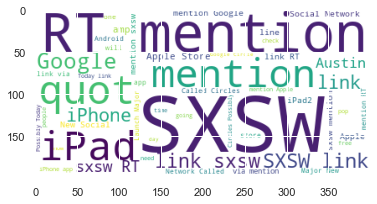

In [27]:
from wordcloud import WordCloud, STOPWORDS
wc = WordCloud(background_color='white',
                    stopwords =  set(STOPWORDS),
                    max_words = 50, 
                    random_state = 42,)
wc.generate(' '.join(train['Product_Description']))
plt.imshow(wc)

# Text Classification

In [28]:
from sklearn.model_selection import train_test_split

X = train['Product_Description']
y = train['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# Multinomial NB

_________________________Classification Report_________________________
              precision    recall  f1-score   support

  Cannot say       0.00      0.00      0.00         0
    Negative       0.01      1.00      0.02         1
    Positive       0.96      0.66      0.78      1130
No sentiment       0.27      0.74      0.39       142

    accuracy                           0.67      1273
   macro avg       0.31      0.60      0.30      1273
weighted avg       0.89      0.67      0.74      1273

_________________________Evaluation Metrics_________________________


Accuracy: 0.667714
Weighted Precision :0.885209


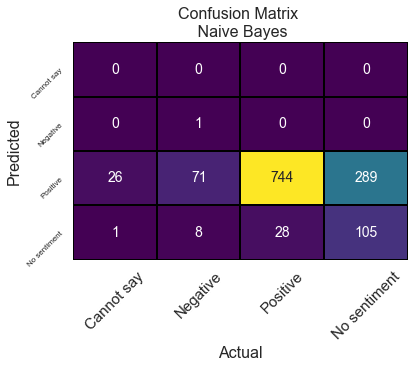

In [29]:
nb = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())
              ])

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y_pred,y_test,target_names=['Cannot say','Negative','Positive','No sentiment'],zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y_pred,y_test))
print("Weighted Precision :%f" % precision_score(y_pred,y_test,average="weighted"))

cm=confusion_matrix(y_pred,y_test)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                   annot_kws={"size":14},cmap='viridis',cbar=False)
g.set_xticklabels(['Cannot say','Negative','Positive','No sentiment'],fontsize = 15,rotation=45)
g.set_yticklabels(['Cannot say','Negative','Positive','No sentiment'],fontsize = 8,rotation=45)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix \n Naive Bayes',size=16)
plt.show()

# Logistic Regression

_________________________Classification Report_________________________
              precision    recall  f1-score   support

  Cannot say       0.00      0.00      0.00         0
    Negative       0.03      0.33      0.05         6
    Positive       0.90      0.69      0.78      1003
No sentiment       0.44      0.65      0.52       264

    accuracy                           0.68      1273
   macro avg       0.34      0.42      0.34      1273
weighted avg       0.80      0.68      0.73      1273

_________________________Evaluation Metrics_________________________


Accuracy: 0.683425
Weighted Precision :0.800988


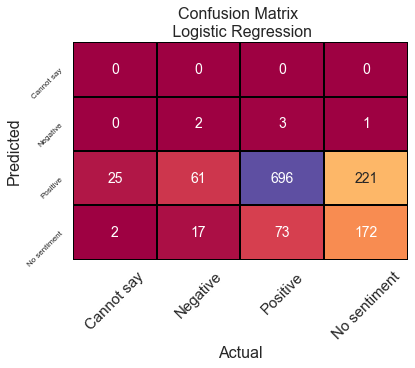

In [30]:
lr = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression())
              ])

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y_pred,y_test,target_names=['Cannot say','Negative','Positive','No sentiment'],zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y_pred,y_test))
print("Weighted Precision :%f" % precision_score(y_pred,y_test,average="weighted"))

cm=confusion_matrix(y_pred,y_test)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Spectral',cbar=False)
g.set_xticklabels(['Cannot say','Negative','Positive','No sentiment'],fontsize = 15,rotation=45)
g.set_yticklabels(['Cannot say','Negative','Positive','No sentiment'],fontsize = 8,rotation=45)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix \n Logistic Regression',size=16)
plt.show()

# Linear SVC

_________________________Classification Report_________________________
              precision    recall  f1-score   support

  Cannot say       0.04      0.10      0.05        10
    Negative       0.26      0.55      0.36        38
    Positive       0.82      0.72      0.77       875
No sentiment       0.54      0.60      0.57       350

    accuracy                           0.68      1273
   macro avg       0.41      0.49      0.44      1273
weighted avg       0.72      0.68      0.70      1273

_________________________Evaluation Metrics_________________________


Accuracy: 0.680283
Weighted Precision :0.718960


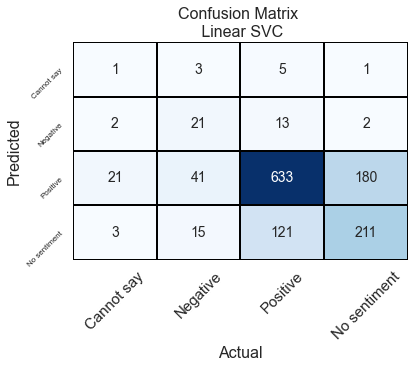

In [31]:
lsvc = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LinearSVC())
              ])

lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)

print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y_pred,y_test,target_names=['Cannot say','Negative','Positive','No sentiment'],zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y_pred,y_test))
print("Weighted Precision :%f" % precision_score(y_pred,y_test,average="weighted"))

cm=confusion_matrix(y_pred,y_test)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Blues',cbar=False)
g.set_xticklabels(['Cannot say','Negative','Positive','No sentiment'],fontsize = 15,rotation=45)
g.set_yticklabels(['Cannot say','Negative','Positive','No sentiment'],fontsize = 8,rotation=45)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix \n Linear SVC',size=16)
plt.show()

# Random Forest

_________________________Classification Report_________________________
              precision    recall  f1-score   support

  Cannot say       0.04      0.12      0.06         8
    Negative       0.20      0.59      0.30        27
    Positive       0.89      0.69      0.78       993
No sentiment       0.40      0.64      0.49       245

    accuracy                           0.67      1273
   macro avg       0.38      0.51      0.41      1273
weighted avg       0.77      0.67      0.71      1273

_________________________Evaluation Metrics_________________________


Accuracy: 0.674784
Weighted Precision :0.773305


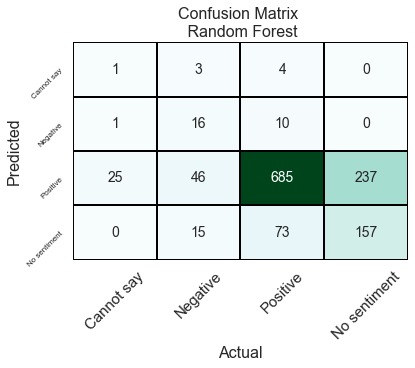

In [32]:
rf = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(n_estimators=300))
              ])

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y_pred,y_test,target_names=['Cannot say','Negative','Positive','No sentiment'],zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y_pred,y_test))
print("Weighted Precision :%f" % precision_score(y_pred,y_test,average="weighted"))


cm=confusion_matrix(y_pred,y_test)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='BuGn',cbar=False)
g.set_xticklabels(['Cannot say','Negative','Positive','No sentiment'],fontsize = 15,rotation=45)
g.set_yticklabels(['Cannot say','Negative','Positive','No sentiment'],fontsize = 8,rotation=45)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix \n Random Forest',size=16)
plt.show()

# XGB Classifier

_________________________Classification Report_________________________
              precision    recall  f1-score   support

  Cannot say       0.00      0.00      0.00         0
    Negative       0.04      0.38      0.07         8
    Positive       0.96      0.65      0.78      1144
No sentiment       0.22      0.73      0.34       121

    accuracy                           0.66      1273
   macro avg       0.31      0.44      0.30      1273
weighted avg       0.89      0.66      0.73      1273

_________________________Evaluation Metrics_________________________


Accuracy: 0.655931
Weighted Precision :0.887536


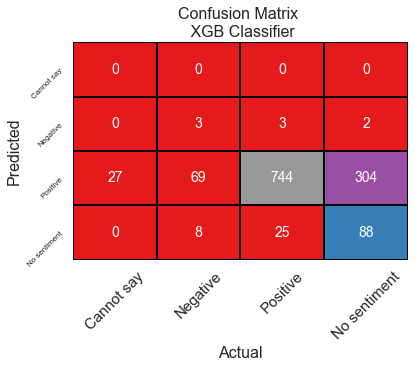

In [33]:
xgb = Pipeline([('vect', TfidfVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier(objective="multi:softmax",n_estimators=200,learning_rate=0.01))
              ])

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y_pred,y_test,target_names=['Cannot say','Negative','Positive','No sentiment'],zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y_pred,y_test))
print("Weighted Precision :%f" % precision_score(y_pred,y_test,average="weighted"))

cm=confusion_matrix(y_pred,y_test)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Set1',cbar=False)
g.set_xticklabels(['Cannot say','Negative','Positive','No sentiment'],fontsize = 15,rotation=45)
g.set_yticklabels(['Cannot say','Negative','Positive','No sentiment'],fontsize = 8,rotation=45)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix \n XGB Classifier',size=16)
plt.show()



# CONCLUSION

Metrics:
#### Multinomial NB - Accuracy:0.66
#### Logistic Regression - Accuracy:0.68.3 
#### Linear SVC - Accuracy:0.68 
#### Random Forest - Accuracy:0.67 
####  XGB Classifier- Accuracy:0.65

 By Observing all models we got Logistic Regression - Accuracy: 68.3% - Weighted Precision: 80% as the highest